In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
E: Package 'module-init-tools' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 121730 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.30-1ubuntu1~bpo22.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.30-1ubuntu1~bpo22.04.1) ...
Setting up google-drive-ocamlfuse (0.7.30-1ubuntu1~bpo22.04.1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
import pandas as pd
data = pd.read_csv("dataset-ner.csv")
data.head(5)

,sentence,word,pos,tag
0,Pertunjukan teater klasik akan diadakan di ged...,Pertunjukan,NN,O
1,Pertunjukan teater klasik akan diadakan di ged...,teater klasik,NN,O
2,Pertunjukan teater klasik akan diadakan di ged...,akan,MD,O
3,Pertunjukan teater klasik akan diadakan di ged...,diadakan,VB,O
4,Pertunjukan teater klasik akan diadakan di ged...,di,IN,O


### Preproses

Membersihkan data dengan mengganti string kosong dan nilai NaN.

In [ ]:
import numpy as np

data.replace('', np.nan, regex=True, inplace = True)
data["sentence"].fillna(method="ffill", inplace = True)
data.tail(10)

,sentence,word,pos,tag
807,Diskusi tentang proyek inovatif di kantor pusa...,.,.,O
808,Permintaan penawaran harga oleh perusahaan OPQ...,Permintaan,NN,O
809,Permintaan penawaran harga oleh perusahaan OPQ...,penawaran,NN,O
810,Permintaan penawaran harga oleh perusahaan OPQ...,harga,NN,O
811,Permintaan penawaran harga oleh perusahaan OPQ...,oleh,IN,O
812,Permintaan penawaran harga oleh perusahaan OPQ...,perusahaan,NN,PERUSAHAAN
813,Permintaan penawaran harga oleh perusahaan OPQ...,OPQ,NNP,PERUSAHAAN
814,Permintaan penawaran harga oleh perusahaan OPQ...,telah,MD,O
815,Permintaan penawaran harga oleh perusahaan OPQ...,diterima,VB,O
816,Permintaan penawaran harga oleh perusahaan OPQ...,.,.,O


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

In [ ]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["word"].values.tolist(),
                                                           s["pos"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

SentenceGetter digunakan untuk mengambil kalimat dari DataFrame data.

In [ ]:
getter = SentenceGetter(data)

In [ ]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[25]

['Mohon',
 'kirimkan',
 'rincian',
 'kontrak',
 'ke',
 'email',
 'saya',
 'di',
 'john@email.com',
 'secepatnya',
 '.']

In [ ]:
labels = [[s[2] for s in sent] for sent in getter.sentences]
print(labels[10])

['O', 'O', 'O', 'O', 'O', 'LOKASI', 'LOKASI', 'PERUSAHAAN', 'PERUSAHAAN', 'WAKTU', 'O']


In [ ]:
tag_values = list(set(data["tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

Membuat sebuah mapping antara tag dan indeksnya. “PAD” ditambahkan sebagai tag tambahan.

In [ ]:
!pip install transformers

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'2.1.0+cu121'

Install dependensi bert

In [ ]:
MAX_LEN = 75
bs = 32

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        tokenized_word = tokenizer.tokenize(str(word))
        n_subwords = len(tokenized_word)
        tokenized_sentence.extend(tokenized_word)
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

Fungsi untuk melakikan tokenisasi pada kalimat namun mempertahankan label asli untuk setiap token

In [ ]:
tokenized_texts_and_labels = list()

for sent, labs in zip(sentences, labels):
  tokenized_texts_and_labels.append(tokenize_and_preserve_labels(sent, labs))

In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [ ]:
print(tokenized_texts[10])
print(labels[10])

['Di', '##sk', '##us', '##i', 'tent', '##ang', 'pro', '##ye', '##k', 'in', '##ova', '##ti', '##f', 'di', 'ka', '##nto', '##r', 'pu', '##sat', 'per', '##usa', '##ha', '##an', 'L', '##M', '##N', 'be', '##so', '##k', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'LOKASI', 'LOKASI', 'LOKASI', 'LOKASI', 'LOKASI', 'PERUSAHAAN', 'PERUSAHAAN', 'PERUSAHAAN', 'PERUSAHAAN', 'PERUSAHAAN', 'PERUSAHAAN', 'PERUSAHAAN', 'WAKTU', 'WAKTU', 'WAKTU', 'O']


In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

Melakukan padding pada sequence token dengan nilai 0.0 hingga mencapai panjang maksimum MAX_LEN. Jika sequence lebih panjang dari MAX_LEN, maka akan dipotong di bagian akhir.

In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

Melakukan padding pada sequence label dengan nilai yang sesuai dengan “PAD” dalam tag2idx hingga mencapai panjang maksimum MAX_LEN. Jika sequence lebih panjang dari MAX_LEN, maka akan dipotong di bagian akhir.

In [ ]:
attention_masks = [[float(i>0) for i in ii] for ii in input_ids]

Membuat attention masks untuk menandai mana token yang merupakan bagian dari input dan mana yang merupakan padding.

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

Membagi data menjadi training set dan validation set dengan proporsi 90:10.

In [ ]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

Mempersiapkan data latihan dan validasi untuk proses latihan model dengan PyTorch

### Model

In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

#### Finetuning

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Mengambil semua parameter model jika full finetune true lalu mendefinisikan bagaimana proses optimasi model dilakukan selama pelatihan

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 100
max_grad_norm = 1.0

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 413.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=4fd7bdf0868efe07a96f3587a02b8d0e258a3b74ae174ab2a5a1ea5e0ea69e4c
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Fungsi menghtiung akurasi.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
def convert_to_list_of_list(tags):
    return [tags[i:i+3] for i in range(0, len(tags), 3)]

In [ ]:
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):

    model.train()

    total_loss = 0

    for step, batch in enumerate(train_dataloader):

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)

        loss = outputs[0]

        loss.backward()

        total_loss += loss.item()

        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    loss_values.append(avg_train_loss)

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():

            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)

        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        eval_loss += outputs[0].mean().item()
        eval_accuracy += flat_accuracy(logits, label_ids)
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    pred_tags = convert_to_list_of_list(pred_tags)
    valid_tags = convert_to_list_of_list(valid_tags)
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: WAKTU seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: LOKASI seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PERUSAHAAN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
Epoch:   1%|          | 1/100 [00:04<07:03,  4.28s/it]

Average train loss: 1.4766038258870442
Validation loss: 1.01591157913208
Validation Accuracy: 0.6733333333333333
Validation F1-Score: 0.0



Epoch:   2%|▏         | 2/100 [00:05<04:07,  2.53s/it]

Average train loss: 0.9511539538701376
Validation loss: 0.8395854234695435
Validation Accuracy: 0.6733333333333333
Validation F1-Score: 0.0



Epoch:   3%|▎         | 3/100 [00:06<03:06,  1.92s/it]

Average train loss: 0.7751294374465942
Validation loss: 0.6522942185401917
Validation Accuracy: 0.7773333333333333
Validation F1-Score: 0.0



Epoch:   4%|▍         | 4/100 [00:07<02:31,  1.58s/it]

Average train loss: 0.6006757219632467
Validation loss: 0.4628901481628418
Validation Accuracy: 0.8866666666666667
Validation F1-Score: 0.0



Epoch:   5%|▌         | 5/100 [00:09<02:17,  1.44s/it]

Average train loss: 0.43251025676727295
Validation loss: 0.3865145742893219
Validation Accuracy: 0.892
Validation F1-Score: 0.0



Epoch:   6%|▌         | 6/100 [00:10<02:07,  1.36s/it]

Average train loss: 0.3312327166398366
Validation loss: 0.32165467739105225
Validation Accuracy: 0.892
Validation F1-Score: 0.0



Epoch:   7%|▋         | 7/100 [00:11<02:01,  1.31s/it]

Average train loss: 0.29608317216237384
Validation loss: 0.29326850175857544
Validation Accuracy: 0.892
Validation F1-Score: 0.0



Epoch:   8%|▊         | 8/100 [00:13<02:09,  1.41s/it]

Average train loss: 0.25699353714783985
Validation loss: 0.2727978825569153
Validation Accuracy: 0.896
Validation F1-Score: 0.0909090909090909



Epoch:   9%|▉         | 9/100 [00:14<02:05,  1.38s/it]

Average train loss: 0.2148407498995463
Validation loss: 0.22099414467811584
Validation Accuracy: 0.9226666666666666
Validation F1-Score: 0.23529411764705882



Epoch:  10%|█         | 10/100 [00:15<02:00,  1.34s/it]

Average train loss: 0.1749995897213618
Validation loss: 0.2011626809835434
Validation Accuracy: 0.932
Validation F1-Score: 0.3714285714285715



Epoch:  11%|█         | 11/100 [00:16<01:57,  1.32s/it]

Average train loss: 0.14437816043694815
Validation loss: 0.1707959622144699
Validation Accuracy: 0.9373333333333334
Validation F1-Score: 0.3888888888888889



Epoch:  12%|█▏        | 12/100 [00:18<01:51,  1.27s/it]

Average train loss: 0.11338010430335999
Validation loss: 0.1574592888355255
Validation Accuracy: 0.948
Validation F1-Score: 0.4864864864864864



Epoch:  13%|█▎        | 13/100 [00:19<01:45,  1.22s/it]

Average train loss: 0.08987234284480412
Validation loss: 0.13000351190567017
Validation Accuracy: 0.964
Validation F1-Score: 0.6582278481012659



Epoch:  14%|█▍        | 14/100 [00:20<01:40,  1.17s/it]

Average train loss: 0.07791626950105031
Validation loss: 0.165241077542305
Validation Accuracy: 0.9533333333333334
Validation F1-Score: 0.6027397260273972



Epoch:  15%|█▌        | 15/100 [00:21<01:39,  1.17s/it]

Average train loss: 0.06635155652960141
Validation loss: 0.11275694519281387
Validation Accuracy: 0.9706666666666667
Validation F1-Score: 0.7088607594936708



Epoch:  16%|█▌        | 16/100 [00:22<01:36,  1.14s/it]

Average train loss: 0.054459543277819954
Validation loss: 0.1465083658695221
Validation Accuracy: 0.9546666666666667
Validation F1-Score: 0.6301369863013699



Epoch:  17%|█▋        | 17/100 [00:23<01:34,  1.14s/it]

Average train loss: 0.04081052541732788
Validation loss: 0.09048151969909668
Validation Accuracy: 0.9746666666666667
Validation F1-Score: 0.7500000000000001



Epoch:  18%|█▊        | 18/100 [00:24<01:34,  1.15s/it]

Average train loss: 0.03708916281660398
Validation loss: 0.1133251041173935
Validation Accuracy: 0.9666666666666667
Validation F1-Score: 0.64



Epoch:  19%|█▉        | 19/100 [00:25<01:33,  1.16s/it]

Average train loss: 0.030076333011190098
Validation loss: 0.14237771928310394
Validation Accuracy: 0.9586666666666667
Validation F1-Score: 0.684931506849315



Epoch:  20%|██        | 20/100 [00:27<01:31,  1.14s/it]

Average train loss: 0.021974404032031696
Validation loss: 0.09385005384683609
Validation Accuracy: 0.9733333333333334
Validation F1-Score: 0.725



Epoch:  21%|██        | 21/100 [00:28<01:26,  1.10s/it]

Average train loss: 0.019837493387361366
Validation loss: 0.11745753139257431
Validation Accuracy: 0.964
Validation F1-Score: 0.6842105263157895



Epoch:  22%|██▏       | 22/100 [00:29<01:23,  1.07s/it]

Average train loss: 0.016193043751021225
Validation loss: 0.13563372194766998
Validation Accuracy: 0.9653333333333334
Validation F1-Score: 0.7200000000000001



Epoch:  23%|██▎       | 23/100 [00:30<01:20,  1.05s/it]

Average train loss: 0.01364818960428238
Validation loss: 0.12473806738853455
Validation Accuracy: 0.9693333333333334
Validation F1-Score: 0.7532467532467533



Epoch:  24%|██▍       | 24/100 [00:31<01:18,  1.04s/it]

Average train loss: 0.011524955121179422
Validation loss: 0.11689990013837814
Validation Accuracy: 0.968
Validation F1-Score: 0.7368421052631577



Epoch:  25%|██▌       | 25/100 [00:32<01:17,  1.03s/it]

Average train loss: 0.008688669496526321
Validation loss: 0.11771975457668304
Validation Accuracy: 0.9693333333333334
Validation F1-Score: 0.7466666666666666



Epoch:  26%|██▌       | 26/100 [00:33<01:16,  1.03s/it]

Average train loss: 0.012169472097108761
Validation loss: 0.12512679398059845
Validation Accuracy: 0.9706666666666667
Validation F1-Score: 0.8051948051948051



Epoch:  27%|██▋       | 27/100 [00:34<01:14,  1.02s/it]

Average train loss: 0.008633020178725323
Validation loss: 0.12649087607860565
Validation Accuracy: 0.9706666666666667
Validation F1-Score: 0.8051948051948051



Epoch:  28%|██▊       | 28/100 [00:35<01:13,  1.02s/it]

Average train loss: 0.005723090764756004
Validation loss: 0.12727448344230652
Validation Accuracy: 0.9693333333333334
Validation F1-Score: 0.7532467532467533



Epoch:  29%|██▉       | 29/100 [00:36<01:12,  1.03s/it]

Average train loss: 0.007016295877595742
Validation loss: 0.13719551265239716
Validation Accuracy: 0.968
Validation F1-Score: 0.7733333333333333



Epoch:  30%|███       | 30/100 [00:37<01:12,  1.04s/it]

Average train loss: 0.0060335928574204445
Validation loss: 0.16515620052814484
Validation Accuracy: 0.9653333333333334
Validation F1-Score: 0.7671232876712328



Epoch:  31%|███       | 31/100 [00:38<01:13,  1.06s/it]

Average train loss: 0.004543579261129101
Validation loss: 0.16708418726921082
Validation Accuracy: 0.9653333333333334
Validation F1-Score: 0.7671232876712328



Epoch:  32%|███▏      | 32/100 [00:39<01:13,  1.08s/it]

Average train loss: 0.005883926215271155
Validation loss: 0.1340607851743698
Validation Accuracy: 0.9693333333333334
Validation F1-Score: 0.7631578947368423



Epoch:  33%|███▎      | 33/100 [00:40<01:11,  1.06s/it]

Average train loss: 0.005056800631185372
Validation loss: 0.10264832526445389
Validation Accuracy: 0.9706666666666667
Validation F1-Score: 0.759493670886076



Epoch:  34%|███▍      | 34/100 [00:41<01:09,  1.05s/it]

Average train loss: 0.004997932352125645
Validation loss: 0.11759093403816223
Validation Accuracy: 0.9693333333333334
Validation F1-Score: 0.717948717948718



Epoch:  35%|███▌      | 35/100 [00:42<01:08,  1.05s/it]

Average train loss: 0.0055278333990524215
Validation loss: 0.17262767255306244
Validation Accuracy: 0.964
Validation F1-Score: 0.75



Epoch:  36%|███▌      | 36/100 [00:43<01:07,  1.05s/it]

Average train loss: 0.004893748400111993
Validation loss: 0.17167825996875763
Validation Accuracy: 0.964
Validation F1-Score: 0.75



Epoch:  37%|███▋      | 37/100 [00:44<01:05,  1.04s/it]

Average train loss: 0.0034944432166715464
Validation loss: 0.15405286848545074
Validation Accuracy: 0.9666666666666667
Validation F1-Score: 0.7368421052631577



Epoch:  38%|███▊      | 38/100 [00:45<01:03,  1.03s/it]

Average train loss: 0.003869975528990229
Validation loss: 0.12902426719665527
Validation Accuracy: 0.972
Validation F1-Score: 0.7692307692307692



Epoch:  39%|███▉      | 39/100 [00:46<01:01,  1.02s/it]

Average train loss: 0.0026170738662282624
Validation loss: 0.12353349477052689
Validation Accuracy: 0.9733333333333334
Validation F1-Score: 0.7948717948717949



Epoch:  40%|████      | 40/100 [00:47<01:00,  1.01s/it]

Average train loss: 0.0037151294915626445
Validation loss: 0.14464488625526428
Validation Accuracy: 0.968
Validation F1-Score: 0.7631578947368423



Epoch:  41%|████      | 41/100 [00:48<00:59,  1.01s/it]

Average train loss: 0.0022458768992995224
Validation loss: 0.1700884848833084
Validation Accuracy: 0.964
Validation F1-Score: 0.7297297297297298



Epoch:  42%|████▏     | 42/100 [00:49<00:58,  1.01s/it]

Average train loss: 0.0031635510191942253
Validation loss: 0.182413712143898
Validation Accuracy: 0.964
Validation F1-Score: 0.7397260273972603



Epoch:  43%|████▎     | 43/100 [00:50<00:57,  1.01s/it]

Average train loss: 0.002666348901887735
Validation loss: 0.17307405173778534
Validation Accuracy: 0.964
Validation F1-Score: 0.7297297297297298



Epoch:  44%|████▍     | 44/100 [00:51<00:56,  1.01s/it]

Average train loss: 0.0020903357847904167
Validation loss: 0.16753274202346802
Validation Accuracy: 0.964
Validation F1-Score: 0.7297297297297298



Epoch:  45%|████▌     | 45/100 [00:52<00:55,  1.01s/it]

Average train loss: 0.0020498900557868183
Validation loss: 0.16067960858345032
Validation Accuracy: 0.964
Validation F1-Score: 0.7297297297297298



Epoch:  46%|████▌     | 46/100 [00:53<00:54,  1.01s/it]

Average train loss: 0.0024136204350118837
Validation loss: 0.1615598499774933
Validation Accuracy: 0.9653333333333334
Validation F1-Score: 0.7200000000000001



Epoch:  47%|████▋     | 47/100 [00:54<00:53,  1.01s/it]

Average train loss: 0.0021477517439052463
Validation loss: 0.15367665886878967
Validation Accuracy: 0.9693333333333334
Validation F1-Score: 0.717948717948718



Epoch:  48%|████▊     | 48/100 [00:55<00:52,  1.01s/it]

Average train loss: 0.00271979176128904
Validation loss: 0.13114622235298157
Validation Accuracy: 0.9706666666666667
Validation F1-Score: 0.7435897435897436



Epoch:  49%|████▉     | 49/100 [00:56<00:51,  1.01s/it]

Average train loss: 0.0023965310538187623
Validation loss: 0.12670283019542694
Validation Accuracy: 0.9706666666666667
Validation F1-Score: 0.7435897435897436



Epoch:  50%|█████     | 50/100 [00:57<00:50,  1.01s/it]

Average train loss: 0.001960836350917816
Validation loss: 0.13379433751106262
Validation Accuracy: 0.9706666666666667
Validation F1-Score: 0.7435897435897436



Epoch:  51%|█████     | 51/100 [00:58<00:49,  1.01s/it]

Average train loss: 0.0026875042046109834
Validation loss: 0.14799173176288605
Validation Accuracy: 0.968
Validation F1-Score: 0.7272727272727272



Epoch:  52%|█████▏    | 52/100 [00:59<00:48,  1.01s/it]

Average train loss: 0.0022507215617224574
Validation loss: 0.15068651735782623
Validation Accuracy: 0.968
Validation F1-Score: 0.7272727272727272



Epoch:  53%|█████▎    | 53/100 [01:00<00:47,  1.01s/it]

Average train loss: 0.00170923905291905
Validation loss: 0.15201371908187866
Validation Accuracy: 0.968
Validation F1-Score: 0.7272727272727272



Epoch:  54%|█████▍    | 54/100 [01:01<00:46,  1.01s/it]

Average train loss: 0.0021070305180425444
Validation loss: 0.152942955493927
Validation Accuracy: 0.968
Validation F1-Score: 0.7272727272727272



Epoch:  55%|█████▌    | 55/100 [01:02<00:45,  1.01s/it]

Average train loss: 0.0021397954939554134
Validation loss: 0.15803375840187073
Validation Accuracy: 0.968
Validation F1-Score: 0.7272727272727272



Epoch:  56%|█████▌    | 56/100 [01:03<00:44,  1.01s/it]

Average train loss: 0.0014694568235427141
Validation loss: 0.17600689828395844
Validation Accuracy: 0.9666666666666667
Validation F1-Score: 0.7567567567567567



Epoch:  57%|█████▋    | 57/100 [01:04<00:43,  1.01s/it]

Average train loss: 0.0022026541798065105
Validation loss: 0.18832911550998688
Validation Accuracy: 0.9666666666666667
Validation F1-Score: 0.7567567567567567



Epoch:  58%|█████▊    | 58/100 [01:05<00:42,  1.02s/it]

Average train loss: 0.002297082217410207
Validation loss: 0.19450388848781586
Validation Accuracy: 0.9666666666666667
Validation F1-Score: 0.7567567567567567



Epoch:  59%|█████▉    | 59/100 [01:06<00:41,  1.01s/it]

Average train loss: 0.0012681182318677504
Validation loss: 0.19399884343147278
Validation Accuracy: 0.9666666666666667
Validation F1-Score: 0.7567567567567567



Epoch:  60%|██████    | 60/100 [01:07<00:40,  1.02s/it]

Average train loss: 0.0014549865542600553
Validation loss: 0.18269029259681702
Validation Accuracy: 0.9666666666666667
Validation F1-Score: 0.7567567567567567



Epoch:  61%|██████    | 61/100 [01:08<00:39,  1.02s/it]

Average train loss: 0.0014536784340937932
Validation loss: 0.17068646848201752
Validation Accuracy: 0.968
Validation F1-Score: 0.7837837837837837



Epoch:  62%|██████▏   | 62/100 [01:09<00:38,  1.02s/it]

Average train loss: 0.0011793067096732557
Validation loss: 0.1620163917541504
Validation Accuracy: 0.9693333333333334
Validation F1-Score: 0.7733333333333333



Epoch:  63%|██████▎   | 63/100 [01:10<00:37,  1.02s/it]

Average train loss: 0.0011531789011011522
Validation loss: 0.1585642695426941
Validation Accuracy: 0.9693333333333334
Validation F1-Score: 0.7532467532467533



Epoch:  64%|██████▍   | 64/100 [01:11<00:36,  1.02s/it]

Average train loss: 0.0017468716056707005
Validation loss: 0.16519424319267273
Validation Accuracy: 0.9693333333333334
Validation F1-Score: 0.7532467532467533



Epoch:  65%|██████▌   | 65/100 [01:12<00:35,  1.02s/it]

Average train loss: 0.0012623773848948379
Validation loss: 0.17387422919273376
Validation Accuracy: 0.968
Validation F1-Score: 0.7837837837837837



Epoch:  66%|██████▌   | 66/100 [01:13<00:34,  1.02s/it]

Average train loss: 0.001102507405448705
Validation loss: 0.18130363523960114
Validation Accuracy: 0.968
Validation F1-Score: 0.7837837837837837



Epoch:  67%|██████▋   | 67/100 [01:15<00:33,  1.03s/it]

Average train loss: 0.0011275841970928013
Validation loss: 0.185614213347435
Validation Accuracy: 0.968
Validation F1-Score: 0.7837837837837837



Epoch:  68%|██████▊   | 68/100 [01:16<00:32,  1.03s/it]

Average train loss: 0.001407186461923023
Validation loss: 0.18863949179649353
Validation Accuracy: 0.968
Validation F1-Score: 0.7837837837837837



Epoch:  69%|██████▉   | 69/100 [01:17<00:31,  1.03s/it]

Average train loss: 0.0011560741695575416
Validation loss: 0.1910391002893448
Validation Accuracy: 0.9666666666666667
Validation F1-Score: 0.7567567567567567



Epoch:  70%|███████   | 70/100 [01:18<00:30,  1.02s/it]

Average train loss: 0.0017622492741793394
Validation loss: 0.18329577147960663
Validation Accuracy: 0.968
Validation F1-Score: 0.7631578947368423



Epoch:  71%|███████   | 71/100 [01:19<00:29,  1.02s/it]

Average train loss: 0.0014558534797591467
Validation loss: 0.16783978044986725
Validation Accuracy: 0.968
Validation F1-Score: 0.7631578947368423



Epoch:  72%|███████▏  | 72/100 [01:20<00:28,  1.02s/it]

Average train loss: 0.0010714000479007761
Validation loss: 0.16386017203330994
Validation Accuracy: 0.968
Validation F1-Score: 0.7631578947368423



Epoch:  73%|███████▎  | 73/100 [01:21<00:27,  1.02s/it]

Average train loss: 0.0012543090463926394
Validation loss: 0.15859170258045197
Validation Accuracy: 0.9693333333333334
Validation F1-Score: 0.7532467532467533



Epoch:  74%|███████▍  | 74/100 [01:22<00:26,  1.03s/it]

Average train loss: 0.0020824322321762643
Validation loss: 0.15887267887592316
Validation Accuracy: 0.9693333333333334
Validation F1-Score: 0.7532467532467533



Epoch:  75%|███████▌  | 75/100 [01:23<00:25,  1.03s/it]

Average train loss: 0.0012480983859859407
Validation loss: 0.1692841351032257
Validation Accuracy: 0.9693333333333334
Validation F1-Score: 0.7532467532467533



Epoch:  76%|███████▌  | 76/100 [01:24<00:24,  1.03s/it]

Average train loss: 0.0014015166088938713
Validation loss: 0.18010732531547546
Validation Accuracy: 0.968
Validation F1-Score: 0.7837837837837837



Epoch:  77%|███████▋  | 77/100 [01:25<00:23,  1.03s/it]

Average train loss: 0.0010332931803228955
Validation loss: 0.18557694554328918
Validation Accuracy: 0.968
Validation F1-Score: 0.7837837837837837



Epoch:  78%|███████▊  | 78/100 [01:26<00:22,  1.03s/it]

Average train loss: 0.0013085547640609245
Validation loss: 0.1859092265367508
Validation Accuracy: 0.968
Validation F1-Score: 0.7733333333333333



Epoch:  79%|███████▉  | 79/100 [01:27<00:21,  1.03s/it]

Average train loss: 0.0012715449556708336
Validation loss: 0.17945879697799683
Validation Accuracy: 0.968
Validation F1-Score: 0.7631578947368423



Epoch:  80%|████████  | 80/100 [01:28<00:20,  1.03s/it]

Average train loss: 0.002397651240850488
Validation loss: 0.17610135674476624
Validation Accuracy: 0.9666666666666667
Validation F1-Score: 0.7368421052631577



Epoch:  81%|████████  | 81/100 [01:29<00:19,  1.03s/it]

Average train loss: 0.0017197434790432453
Validation loss: 0.16725389659404755
Validation Accuracy: 0.9693333333333334
Validation F1-Score: 0.7532467532467533



Epoch:  82%|████████▏ | 82/100 [01:30<00:18,  1.03s/it]

Average train loss: 0.0015423515578731894
Validation loss: 0.15991877019405365
Validation Accuracy: 0.9693333333333334
Validation F1-Score: 0.7532467532467533



Epoch:  83%|████████▎ | 83/100 [01:31<00:17,  1.03s/it]

Average train loss: 0.0011834047424296539
Validation loss: 0.1597413867712021
Validation Accuracy: 0.9693333333333334
Validation F1-Score: 0.7532467532467533



Epoch:  84%|████████▍ | 84/100 [01:32<00:16,  1.03s/it]

Average train loss: 0.0013668658793903887
Validation loss: 0.16314294934272766
Validation Accuracy: 0.9693333333333334
Validation F1-Score: 0.7532467532467533



Epoch:  85%|████████▌ | 85/100 [01:33<00:15,  1.03s/it]

Average train loss: 0.003289223551594963
Validation loss: 0.1688416600227356
Validation Accuracy: 0.9693333333333334
Validation F1-Score: 0.7532467532467533



Epoch:  86%|████████▌ | 86/100 [01:34<00:14,  1.03s/it]

Average train loss: 0.001224734471179545
Validation loss: 0.17667004466056824
Validation Accuracy: 0.9666666666666667
Validation F1-Score: 0.7368421052631577



Epoch:  87%|████████▋ | 87/100 [01:35<00:13,  1.03s/it]

Average train loss: 0.0015184009680524468
Validation loss: 0.182500958442688
Validation Accuracy: 0.9666666666666667
Validation F1-Score: 0.7368421052631577



Epoch:  88%|████████▊ | 88/100 [01:36<00:12,  1.03s/it]

Average train loss: 0.0010713072066816192
Validation loss: 0.18474029004573822
Validation Accuracy: 0.9666666666666667
Validation F1-Score: 0.7368421052631577



Epoch:  89%|████████▉ | 89/100 [01:37<00:11,  1.03s/it]

Average train loss: 0.001026757371922334
Validation loss: 0.18632197380065918
Validation Accuracy: 0.9666666666666667
Validation F1-Score: 0.7368421052631577



Epoch:  90%|█████████ | 90/100 [01:38<00:10,  1.03s/it]

Average train loss: 0.0009089636926849683
Validation loss: 0.1869964748620987
Validation Accuracy: 0.9666666666666667
Validation F1-Score: 0.7368421052631577



Epoch:  91%|█████████ | 91/100 [01:39<00:09,  1.03s/it]

Average train loss: 0.0011477884060392778
Validation loss: 0.1872357577085495
Validation Accuracy: 0.9666666666666667
Validation F1-Score: 0.7368421052631577



Epoch:  92%|█████████▏| 92/100 [01:40<00:08,  1.03s/it]

Average train loss: 0.0010963747821127374
Validation loss: 0.18686895072460175
Validation Accuracy: 0.968
Validation F1-Score: 0.7631578947368423



Epoch:  93%|█████████▎| 93/100 [01:41<00:07,  1.03s/it]

Average train loss: 0.0009952269804974396
Validation loss: 0.18619565665721893
Validation Accuracy: 0.968
Validation F1-Score: 0.7631578947368423



Epoch:  94%|█████████▍| 94/100 [01:42<00:06,  1.03s/it]

Average train loss: 0.0010077449454305072
Validation loss: 0.18508091568946838
Validation Accuracy: 0.968
Validation F1-Score: 0.7631578947368423



Epoch:  95%|█████████▌| 95/100 [01:43<00:05,  1.03s/it]

Average train loss: 0.0010075178967478375
Validation loss: 0.1844966560602188
Validation Accuracy: 0.968
Validation F1-Score: 0.7631578947368423



Epoch:  96%|█████████▌| 96/100 [01:44<00:04,  1.03s/it]

Average train loss: 0.0010679431143216789
Validation loss: 0.18461190164089203
Validation Accuracy: 0.968
Validation F1-Score: 0.7631578947368423



Epoch:  97%|█████████▋| 97/100 [01:45<00:03,  1.03s/it]

Average train loss: 0.0009589910817643007
Validation loss: 0.18458791077136993
Validation Accuracy: 0.968
Validation F1-Score: 0.7631578947368423



Epoch:  98%|█████████▊| 98/100 [01:46<00:02,  1.03s/it]

Average train loss: 0.0012885986361652613
Validation loss: 0.1847997009754181
Validation Accuracy: 0.968
Validation F1-Score: 0.7631578947368423



Epoch:  99%|█████████▉| 99/100 [01:47<00:01,  1.03s/it]

Average train loss: 0.0008654320457329353
Validation loss: 0.18519090116024017
Validation Accuracy: 0.968
Validation F1-Score: 0.7631578947368423



Epoch: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]

Average train loss: 0.0008662979234941304
Validation loss: 0.18530689179897308
Validation Accuracy: 0.968
Validation F1-Score: 0.7631578947368423



Mengatur model ke mode pelatihan. Melakukan iterasi pada setiap batch dalam data latihan. Setiap batch diproses oleh model, dan gradien dihitung dan diterapkan untuk memperbarui parameter model lalu mengatur gradien menjadi 0, dan melakukan forward, backward, optimizer dan eval. prosesnya adalah pelatihan dan validasi model untuk sejumlah epoch yang ditentukan

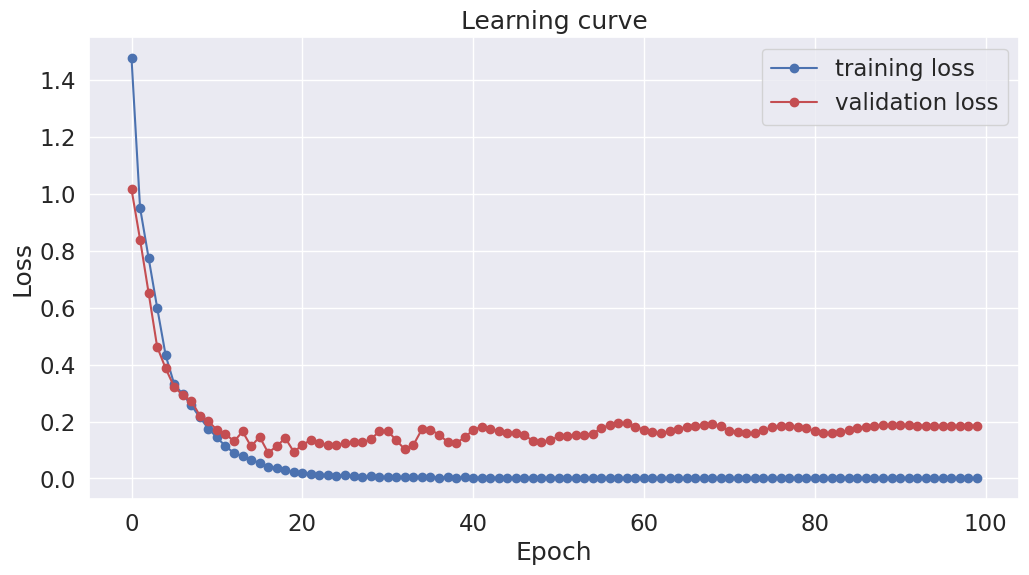

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

menampilkan learning curve dari loss training dan validation

In [ ]:
test_sentence = """
Saya akan menghadiri konser di Jakarta pada hari Sabtu.
"""

In [ ]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [ ]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [ ]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

PAD	[CLS]
O	Saya
O	akan
O	menghadiri
O	konser
O	di
PAD	Jakarta
O	pada
O	hari
WAKTU	Sabtu
O	.
O	[SEP]


### Inference

In [ ]:
def extract_info(text):
    tokenized_sentence = tokenizer.encode(text)
    input_ids = torch.tensor([tokenized_sentence]).cuda()

    with torch.no_grad():
        output = model(input_ids)

    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []

    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tag_values[label_idx])
            new_tokens.append(token)

    info = {"Location": [], "Time": [], "Email": [], "Company": []}
    for token, label in zip(new_tokens, new_labels):
        if label == "LOKASI":
            info["Location"].append(token)
        elif label == "WAKTU":
            info["Time"].append(token)
        elif label == "EMAIL" or label == "TAG-EMAIL":
            info["Email"].append(token)
        elif label == "PERUSAHAAN":
            info["Company"].append(token)

    return info

In [ ]:
text = "Saya akan menghadiri konser di Jakarta pada hari Sabtu."
info = extract_info(text)
print(info)

{'Location': [], 'Time': ['Sabtu'], 'Email': [], 'Company': []}


In [ ]:
text = "Tolong kirimkan beberapa dokumen ke email lisa dari perusahaan BP di alamat lisa@email.com."
info = extract_info(text)
print(info)

{'Location': [], 'Time': [], 'Email': ['@', 'email', '.'], 'Company': ['BP']}


In [ ]:
text = "Mohon kirimkan rincian kontrak ke email saya di john@email.com secepatnya."
info = extract_info(text)
print(info)

{'Location': [], 'Time': [], 'Email': ['@', 'email', '.'], 'Company': []}


In [ ]:
model.save_pretrained('/content/model')


In [ ]:
# model = BertForTokenClassification.from_pretrained('/content/model')